# Figure 3

In [1]:
source(here::here("code/init.R"))

ℹ Parallelization enabled. Using 102 threads.



## Figure 3A

In [2]:
atac_scores_meso <- readRDS(here("data/stats/atac_scores_meso.rds"))

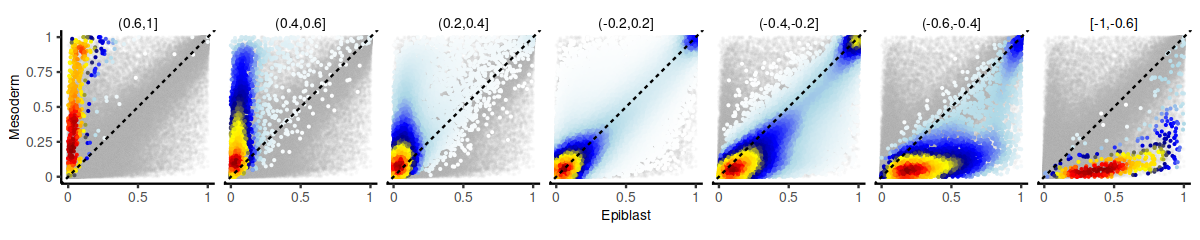

In [3]:
sps(10, 2)
atac_scores_meso <- atac_scores_meso %>%
    mutate(grp = cut(pred_diff, c(-1, -0.6, -0.4, -0.2, 0.2, 0.4, 0.6, 1), include.lowest = TRUE)) %>%
    mutate(grp = forcats::fct_rev(grp)) %>%
    as_tibble()

bg <- atac_scores_meso %>%
    plyr::ddply("grp", function(x) {
        atac_scores_meso %>%
            mutate(grp = x$grp[1])
    })
fg <- atac_scores_meso %>%
    plyr::ddply("grp", function(x) {
        x %>%
            select(nas_bin1, obs4) %>%
            mutate(col = densCols(., bandwidth = 0.06, colramp = colorRampPalette(c("white", "lightblue", "blue", "darkblue", "yellow", "gold", "orange", "red", "darkred")))) %>%
            mutate(grp = x$grp[1])
    })

p <- bg %>%
    ggplot(aes(x = nas_bin1, y = obs4)) +
    geom_point(alpha = 0.05, size = 0.05, color = "gray") +
    geom_point(data = fg, aes(color = col), shape = 19, size = 0.1) +
    scale_color_identity() +
    facet_grid(. ~ grp) +
    guides(color = "none", size = "none", alpha = "none") +
    theme(aspect.ratio = 1) +
    scale_y_continuous(name = "Mesoderm", labels = scales::label_number(drop0trailing = TRUE), limits = c(0, 1)) +
    scale_x_continuous(name = "Epiblast", labels = scales::label_number(drop0trailing = TRUE), limits = c(0, 1), breaks = c(0, 0.5, 1)) +
    geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed")

p

In [4]:
dim(atac_scores_meso)

[1] 129963      8

## Figure 3B

In [5]:
r2_gastru <- fread(here("data/stats/r2_gastrulation.csv"))
model_traj_map <- c(
    "meso" = "Epi->Meso",
    "endo" = "Epi->Endo",
    "cnp" = "Epi->Ecto",
    "exe" = "Meso->Exe",
    "caud" = "Meso->Caudal-Meso",
    "card" = "Meso->Cardio-Meso"
)
r2_gastru <- r2_gastru %>%
    mutate(traj = model_traj_map[model]) %>%
    mutate(traj = factor(traj, levels = model_traj_map))

r2_bm <- fread(here("data/stats/r2_bm.csv"))
model_traj_map_bm <- c(
    "cmp" = "HSC->CMP",
    "mep" = "CMP->MEP",
    "clp" = "CMP->CLP"
)
r2_bm <- r2_bm %>%
    mutate(traj = model_traj_map_bm[model]) %>%
    mutate(traj = factor(traj, levels = model_traj_map_bm))


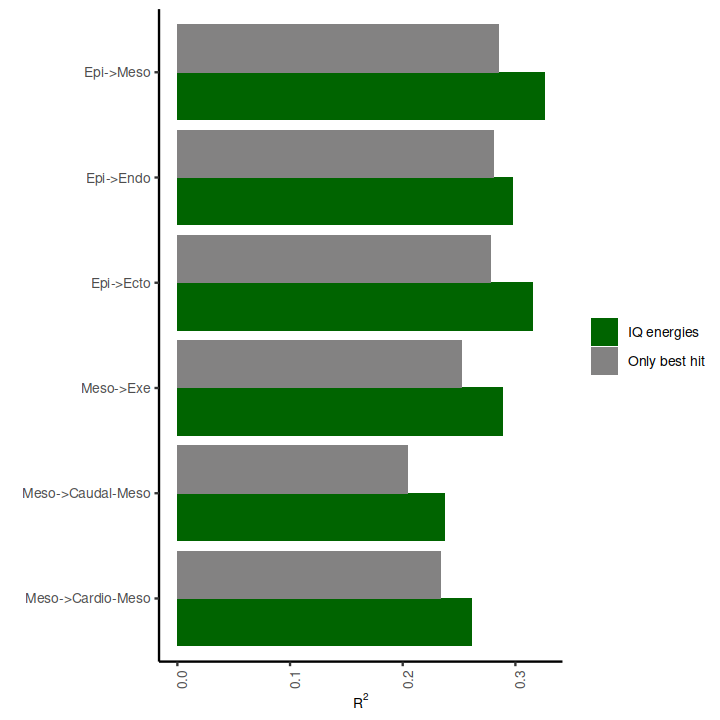

In [6]:
sps(6, 6)
p <- r2_gastru %>%
    filter(type %in% c("Iceqream (non-linear)", "Iceqream (non-linear, max)")) %>%
    mutate(type = case_when(
        type == "Iceqream (non-linear, max)" ~ "Only best hit",
        type == "Iceqream (non-linear)" ~ "IQ energies"
    )) %>%
    select(traj, r2 = r2_test, type) %>%
    mutate(traj = forcats::fct_rev(traj)) %>%
    ggplot(aes(x = traj, y = r2, fill = type)) +
    geom_col(position = "dodge") +
    labs(x = "", y = expression(R^2)) +
    scale_fill_manual(name = "", values = c("IQ energies" = "darkgreen", "Only best hit" = "#838282")) +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    coord_flip()

p

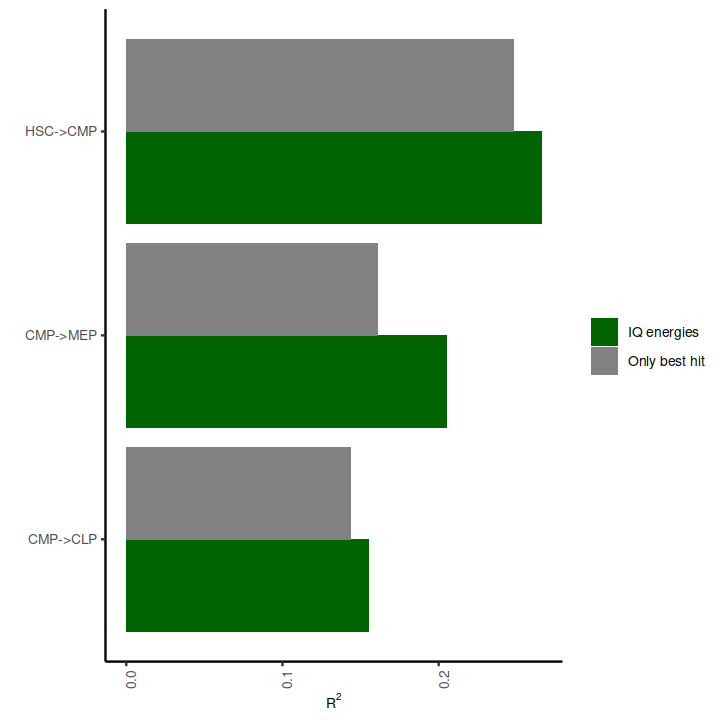

In [7]:
sps(6, 6)
p <- r2_bm %>%
    filter(type %in% c("Iceqream (non-linear)", "Iceqream (non-linear, max)")) %>%
    mutate(type = case_when(
        type == "Iceqream (non-linear, max)" ~ "Only best hit",
        type == "Iceqream (non-linear)" ~ "IQ energies"
    )) %>%
    select(traj, r2 = r2_test, type) %>%
    mutate(traj = forcats::fct_rev(traj)) %>%
    ggplot(aes(x = traj, y = r2, fill = type)) +
    geom_col(position = "dodge") +
    labs(x = "", y = expression(R^2)) +
    scale_fill_manual(name = "", values = c("IQ energies" = "darkgreen", "Only best hit" = "#838282")) +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    coord_flip()

p

## Figure 3C

In [8]:
get_motif_df_q <- function(motif, e_lse, e_max, model_list, traj,
                           threshold = 7.5,
                           sh_q = 0.7,
                           mm_q = 0.4,
                           sh_thresh = -0.5,
                           mm_thresh = -1,
                           mm_bottom_q = 0.2
                           ) {
    df <- e_lse %>%
        select(lse = !!sym(motif)) %>%
        mutate(max = e_max[, motif]) %>%
        mutate(motif = motif)
    df %>%
        mutate(above = lse >= threshold | max >= threshold) %>%
        mutate(type = case_when(
            above & (max - lse) >= quantile((max - lse)[above], sh_q) ~ "Single-High",
            above & (max - lse) < (quantile((max - lse)[above], sh_q) + mm_thresh) ~ "Multi-Medium",
            !above ~ "Low-Energy",
            TRUE ~ "Other"
        )) %>%
        mutate(type = factor(type, levels = c("Single-High", "Multi-Medium", "Low-Energy", "Other"))) %>%
        mutate(diff = model_list[[traj]]@diff_score) %>%
        # add a ks test of multi-medium diff vs single-high diff
        mutate(
            ks_pv = ks.test(diff[type == "Multi-Medium"], diff[type == "Single-High"])$p.value,
            ks_stat = ks.test(diff[type == "Multi-Medium"], diff[type == "Single-High"])$statistic
        )
}

In [9]:
model_list_gastru <- readr::read_rds(here("data/models/gastrulation_models_homogenized.rds"))

In [10]:
# get motif df for all motifs and all trajectories
e_lse <- readr::read_rds(here("data/low-affinity/pbm_lse.rds"))
e_max <- readr::read_rds(here("data/low-affinity/pbm_max.rds"))
motif_df_all <- purrr::imap_dfr(model_list_gastru, function(model, traj) {
    purrr::imap_dfr(model@motif_models, function(motif, motif_name) {
        motif_df <- get_motif_df_q(motif_name, e_lse, e_max, model_list_gastru, traj)
        motif_df <- motif_df %>%
            mutate(traj = traj, motif = motif_name, r2 = model@features_r2[motif_name])
        motif_df
    })
}) %cache_df% here("data/low-affinity/motif_low_affinity_df_all.tsv") %>%
    as_tibble()

Using cached dataframe from '/net/mraid20/ifs/wisdom/tanay_lab/tgdata/users/aviezerl/proj/motif_reg/IQ-paper/data/low-affinity/motif_low_affinity_df_all.tsv'



In [11]:
# decide on direction based on the diff in above vs !above
motif_scores <- motif_df_all %>%
    group_by(motif, traj) %>%
    summarise(
        direction = ifelse(mean(diff[lse >= 7.5]) > mean(diff[lse <= 3]), "opening", "closing"),
        score = mean(diff[type == "Multi-Medium"]) - mean(diff[type == "Single-High"]),
        pv_low_vs_high = ks.test(diff[lse >= 7.5], diff[lse <= 3])$p.value,
        pv = ks_pv[1],
        signif = pv < 0.05 & pv_low_vs_high < 0.05,
        score = ifelse(direction == "closing", -score, score),
        r2 = r2[1]
    ) %>%
    ungroup()

Warning message:
“There were 138 warnings in `summarise()`.
The first warning was:
ℹ In argument: `pv_low_vs_high = ks.test(diff[lse >= 7.5], diff[lse <=
  3])$p.value`.
ℹ In group 1: `motif = "ACACCC"` `traj = "card"`.
Caused by warning in `ks.test.default()`:
! p-value will be approximate in the presence of ties
ℹ Run `dplyr::last_dplyr_warnings()` to see the 137 remaining warnings.”


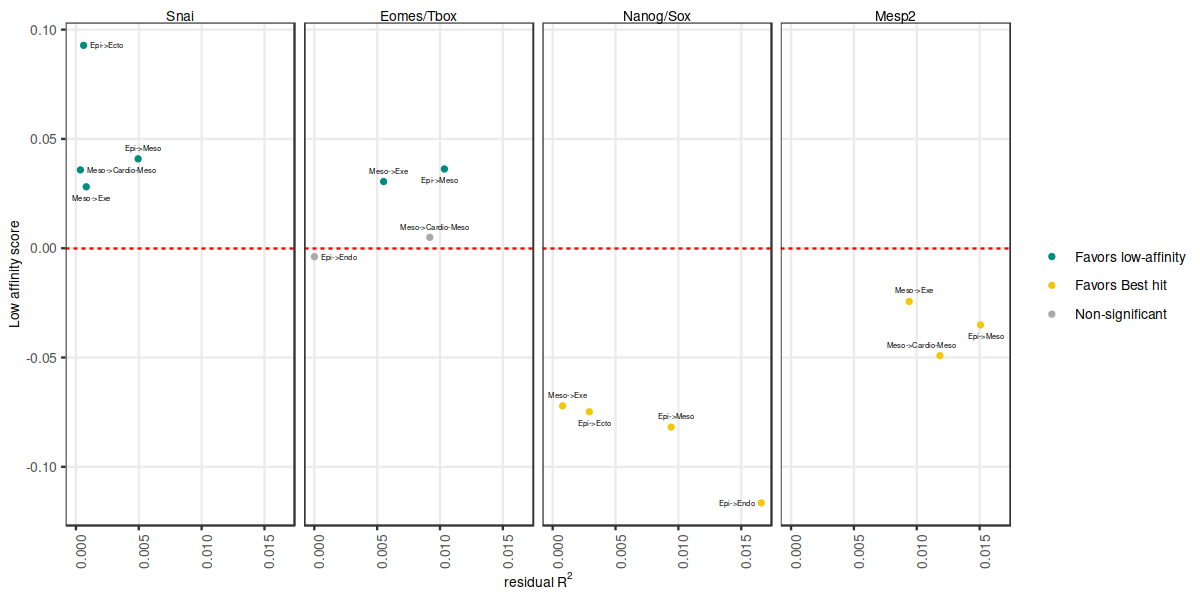

In [12]:
sps(10, 5)

motifs <- c("Snai", "Eomes/Tbox", "Nanog/Sox", "Mesp2")

p <- motif_scores %>%
    filter(motif %in% motifs) %>%
    mutate(motif = factor(motif, levels = motifs)) %>%
    mutate(type = case_when(
        !signif ~ "Non-significant",
        score >= 0 ~ "Favors low-affinity",
        score < 0 ~ "Favors Best hit"
    )) %>%
    mutate(type = factor(type, levels = c("Favors low-affinity", "Favors Best hit", "Non-significant"))) %>%
    mutate(traj = model_traj_map[traj]) %>%
    ggplot(aes(y = score, x = r2, label = traj, color = type)) +
    geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
    geom_point(size = 1) +
    ggrepel::geom_text_repel(family = "ArialMT", size = 1.5, color = "black") +
    theme_arial_bw() +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    scale_color_manual(name = "", values = c("Favors low-affinity" = "#008b7f", "Favors Best hit" = "#f4c60c", "Non-significant" = "darkgray")) +
     facet_grid(. ~ motif) +
    xlab(expression(residual~R^2)) +
    ylab("Low affinity score")

p

In [13]:
motif_scores_tab <- motif_scores %>%
    mutate(type = case_when(
        !signif ~ "Non-significant",
        score >= 0 ~ "Favors low-affinity",
        score < 0 ~ "Favors Best hit"
    )) %>%
    mutate(type = factor(type, levels = c("Favors low-affinity", "Favors Best hit", "Non-significant"))) %>%
    mutate(traj = model_traj_map[traj]) %>%
    rename("Trajectory" = traj, "Motif" = motif, "Direction" = direction, "R^2" = r2, "Score" = score, "P-value" = pv, "P-value (low vs high)" = pv_low_vs_high, "Significant" = signif, "Type" = type)
head(motif_scores_tab)

Motif,Trajectory,Direction,Score,P-value (low vs high),P-value,Significant,R^2,Type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>
ACACCC,Meso->Cardio-Meso,closing,0.0196996346,8.340908e-145,6.686361e-06,TRUE,0.0005398556,Favors low-affinity
ACACCC,Meso->Exe,closing,0.0307550821,1.917432e-126,1.143025e-07,TRUE,0.0008966994,Favors low-affinity
ACG,Meso->Cardio-Meso,opening,0.0003293589,5.822502e-09,3.393219e-01,FALSE,0.0001972330,Non-significant
A__TGAAT,Epi->Endo,closing,-0.0759557609,2.825768e-01,2.283046e-240,FALSE,0.0030616936,Non-significant
A__TGAAT,Meso->Exe,opening,0.0439813711,1.904467e-01,6.879116e-84,FALSE,0.0004088919,Non-significant
A__TGAAT,Epi->Meso,closing,-0.0441847411,1.224433e-01,1.457401e-164,FALSE,0.0011462207,Non-significant


## Figure 3D

In [14]:
gastru_models <- readr::read_rds(here("data/models/gastrulation_models_with_interactions.rds"))
traj_model_meso <- rename_motif_models(gastru_models$traj_model_meso, c(
    SCENIC.jaspar__MA0807.1 = "Eomes/Tbox", SCENIC.cisbp__M07968 = "Gata",
    HOCOMOCO.SOX2_MOUSE.H11MO.0.A = "Nanog/Sox", SCENIC.elemento__CACCTGG = "Snai",
    SCENIC.homer__TAATTAGN_Lhx2 = "Lhx2/Emx", SCENIC.taipale_cyt_meth__MESP2_NAMCATATGKYN_eDBD = "Mesp2",
    SCENIC.jaspar__MA0867.2 = "Tcf", HOCOMOCO.SMAD2_HUMAN.H11MO.0.A = "Smad4",
    JASPAR.nub = "Pou3", SCENIC.predrem__nrMotif1975 = "Tbx1", JASPAR.Hnf1A = "Hnf1a",
    SCENIC.cisbp__M02420 = "Dmrta2", SCENIC.yetfasco__YGL096W_494 = "Meis"
))


Warning message in eval(family$initialize):
“non-integer #successes in a binomial glm!”


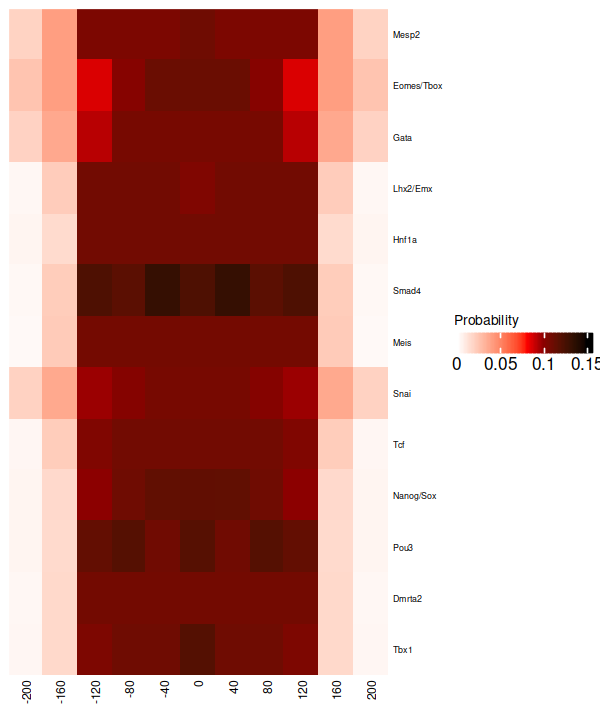

In [15]:
pos_motifs <- c("Mesp2", "Eomes/Tbox", "Gata", "Lhx2/Emx", "Hnf1a", "Smad4", "Meis")
neg_motifs <- c("Snai", "Tcf", "Nanog/Sox", "Pou3", "Dmrta2", "Tbx1")
stopifnot(all(names(traj_model_meso@motif_models) %in% c(pos_motifs, neg_motifs)))

spat_df <- purrr::imap_dfr(traj_model_meso@motif_models, ~ {
    .x$spat %>%
        mutate(motif = .y)
})
motif_ord <- c(pos_motifs, neg_motifs)
spat_mat <- spat_df %>%
    spread(bin, spat_factor) %>%
    column_to_rownames("motif") %>%
    as.matrix()
spat_mat <- spat_mat[motif_ord, ]
colnames(spat_mat) <- as.character(as.numeric(colnames(spat_mat)) - as.numeric(colnames(spat_mat)[6]))

sps(5, 6)
hm_mouse <- ComplexHeatmap::Heatmap(spat_mat,
    cluster_columns = FALSE, cluster_rows = FALSE, show_column_names = TRUE, name = "Probability",
    col = circlize::colorRamp2(c(0, 0.08, 0.1, 0.15), c("white", "red", "darkred", "black")),
    show_row_dend = FALSE,
    row_title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), column_title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), row_names_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), column_names_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 7),
    use_raster = TRUE,
    heatmap_legend_param = list(direction = "horizontal", title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 8), legend_position = "bottom")
)

hm_mouse

In [16]:
model_list_bm <- readr::read_rds(here("data/models/bm_models_homogenized.rds"))
traj_model_bm <- model_list_bm$cmp

In [17]:
spat_df_bm <- purrr::imap_dfr(traj_model_bm@motif_models, ~ {
    .x$spat %>%
        mutate(motif = .y)
})
spat_mat_bm <- spat_df_bm %>%
    spread(bin, spat_factor) %>%
    column_to_rownames("motif") %>%
    as.matrix()
colnames(spat_mat_bm) <- as.character(as.numeric(colnames(spat_mat_bm)) - as.numeric(colnames(spat_mat_bm)[6]))

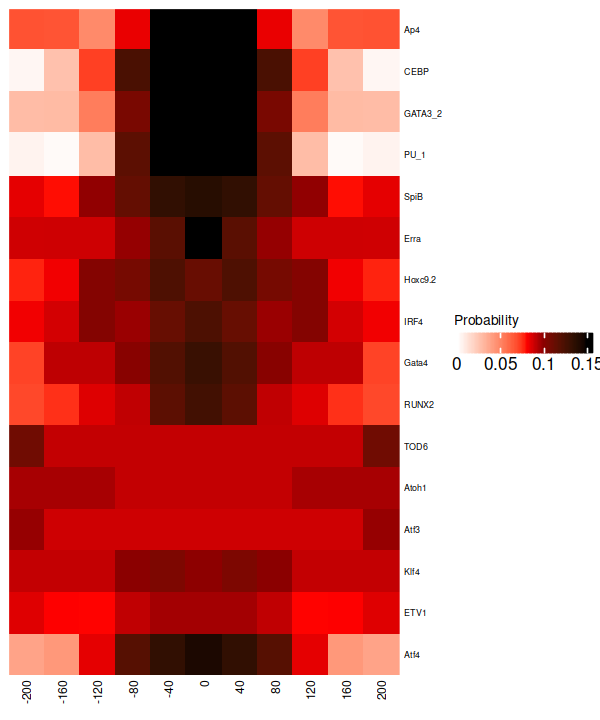

In [18]:
set_plot_size(5, 6)
hm_bm <- ComplexHeatmap::Heatmap(spat_mat_bm,
    cluster_columns = FALSE, cluster_rows = TRUE, show_column_names = TRUE, name = "Probability",
    col = circlize::colorRamp2(c(0, 0.08, 0.1, 0.15), c("white", "red", "darkred", "black")),
    show_row_dend = FALSE,
    row_title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), column_title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), row_names_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 5), column_names_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 7),
    use_raster = TRUE,
    heatmap_legend_param = list(direction = "horizontal", title_gp = grid::gpar(fontfamily = "ArialMT", fontsize = 8), legend_position = "bottom")
)

hm_bm

## Figure 3E

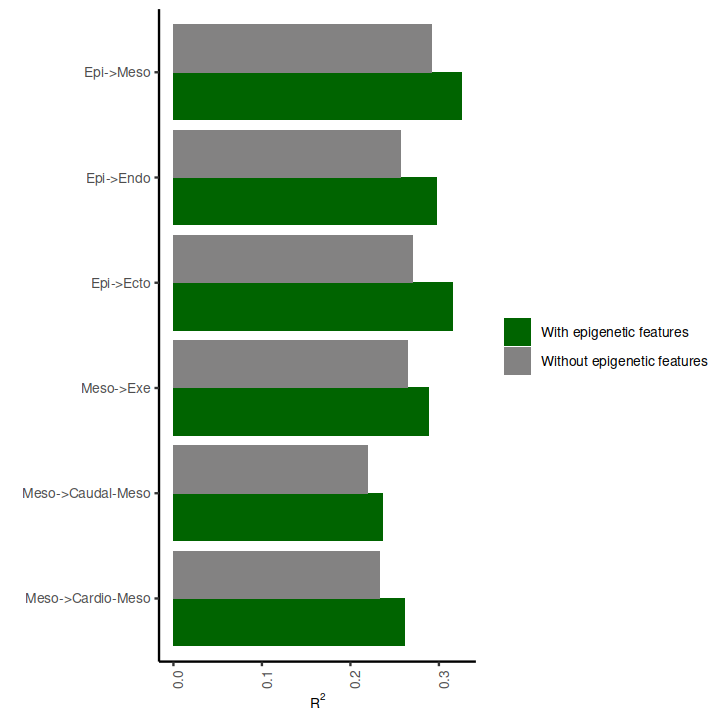

In [19]:
sps(6, 6)
p <- r2_gastru %>%
    filter(type %in% c("Iceqream (non-linear)", "Iceqream (non-linear, no additional)")) %>%
    mutate(type = case_when(
        type == "Iceqream (non-linear)" ~ "With epigenetic features",
        type == "Iceqream (non-linear, no additional)" ~ "Without epigenetic features"
    )) %>%
    select(traj, r2 = r2_test, type) %>%
    mutate(traj = forcats::fct_rev(traj)) %>%
    ggplot(aes(x = traj, y = r2, fill = type)) +
    geom_col(position = "dodge") +
    labs(x = "", y = expression(R^2)) +
    scale_fill_manual(name = "", values = c("With epigenetic features" = "darkgreen", "Without epigenetic features" = "#838282")) +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    coord_flip()

p

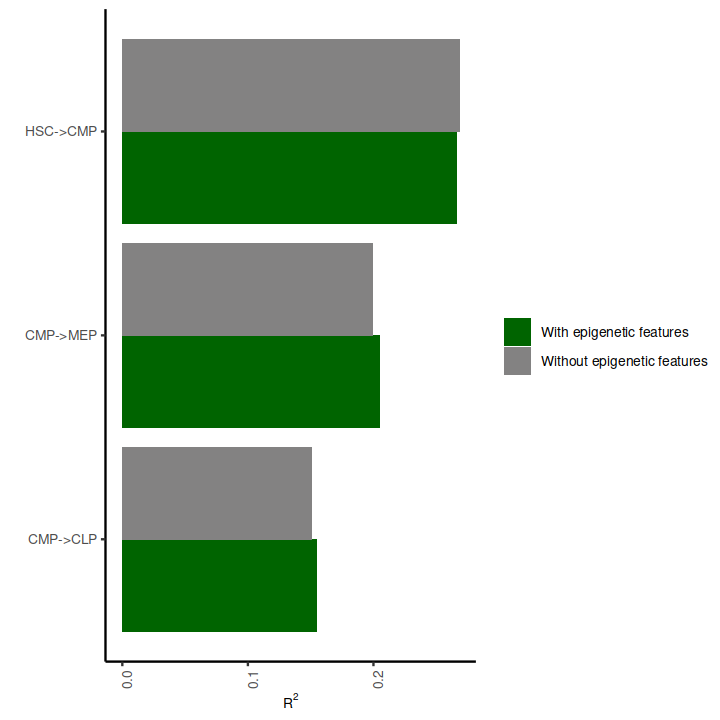

In [20]:
sps(6, 6)

p <- r2_bm %>%
    filter(type %in% c("Iceqream (non-linear)", "Iceqream (non-linear, no additional)")) %>%
    mutate(type = case_when(
        type == "Iceqream (non-linear)" ~ "With epigenetic features",
        type == "Iceqream (non-linear, no additional)" ~ "Without epigenetic features"
    )) %>%
    select(traj, r2 = r2_test, type) %>%
    mutate(traj = forcats::fct_rev(traj)) %>%
    ggplot(aes(x = traj, y = r2, fill = type)) +
    geom_col(position = "dodge") +
    labs(x = "", y = expression(R^2)) +
    scale_fill_manual(name = "", values = c("With epigenetic features" = "darkgreen", "Without epigenetic features" = "#838282")) +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    coord_flip()

p

## Figure 3F

In [21]:
# we used iceqream::add_features_r2 on each model to compute residual R2 for each feature
feat_r2_gastru <- readr::read_rds(here("data/stats/feat_r2_gastru.rds"))

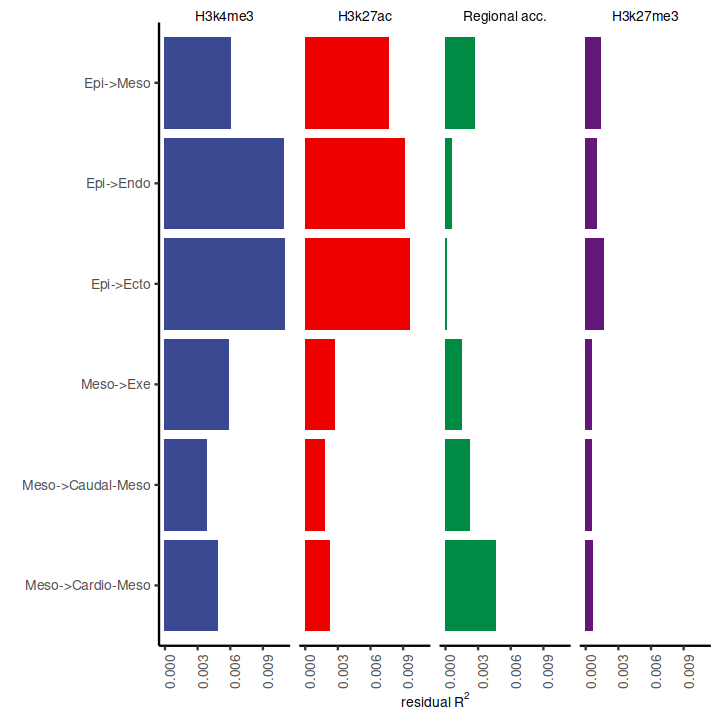

In [22]:
p <- feat_r2_gastru %>%
    filter(!(feat %in% c("CpG cont.", "Spatial ratio"))) %>%
    mutate(feat = forcats::fct_reorder(feat, desc(r2))) %>%
    ggplot(aes(x = traj, y = r2, fill = feat)) +
    geom_col(position = "dodge") +
    ggsci::scale_fill_aaas(name = "") +
    theme_arial_classic() +
    theme(axis.text.x = ggplot2::element_text(angle = 90, hjust = 1)) +
    labs(y = expression(residual~R^2), x = "") +
    coord_flip() +
    facet_grid(. ~ feat) +
    guides(fill = "none")

p

# Figure 3G

In [23]:
inter_betas <- fread(here("data/stats/epiblast_to_mesoderm_interaction_beta.csv"))
add_key <- c(
    k27me3 = "K27me3", k27ac = "K27ac", k4me1 = "K4me1", k4me3 = "K4me3",
    cg_cont = "CpG cont.", spatial_ratio = "Peak shape", prox_bin1_punc_all = "Reg. ATAC"
)

Warning message:
“The `area` argument of `layout_with_fr()` is deprecated as of igraph 0.8.0.”
Warning message:
“The `repulserad` argument of `layout_with_fr()` is deprecated as of igraph
0.8.0.”


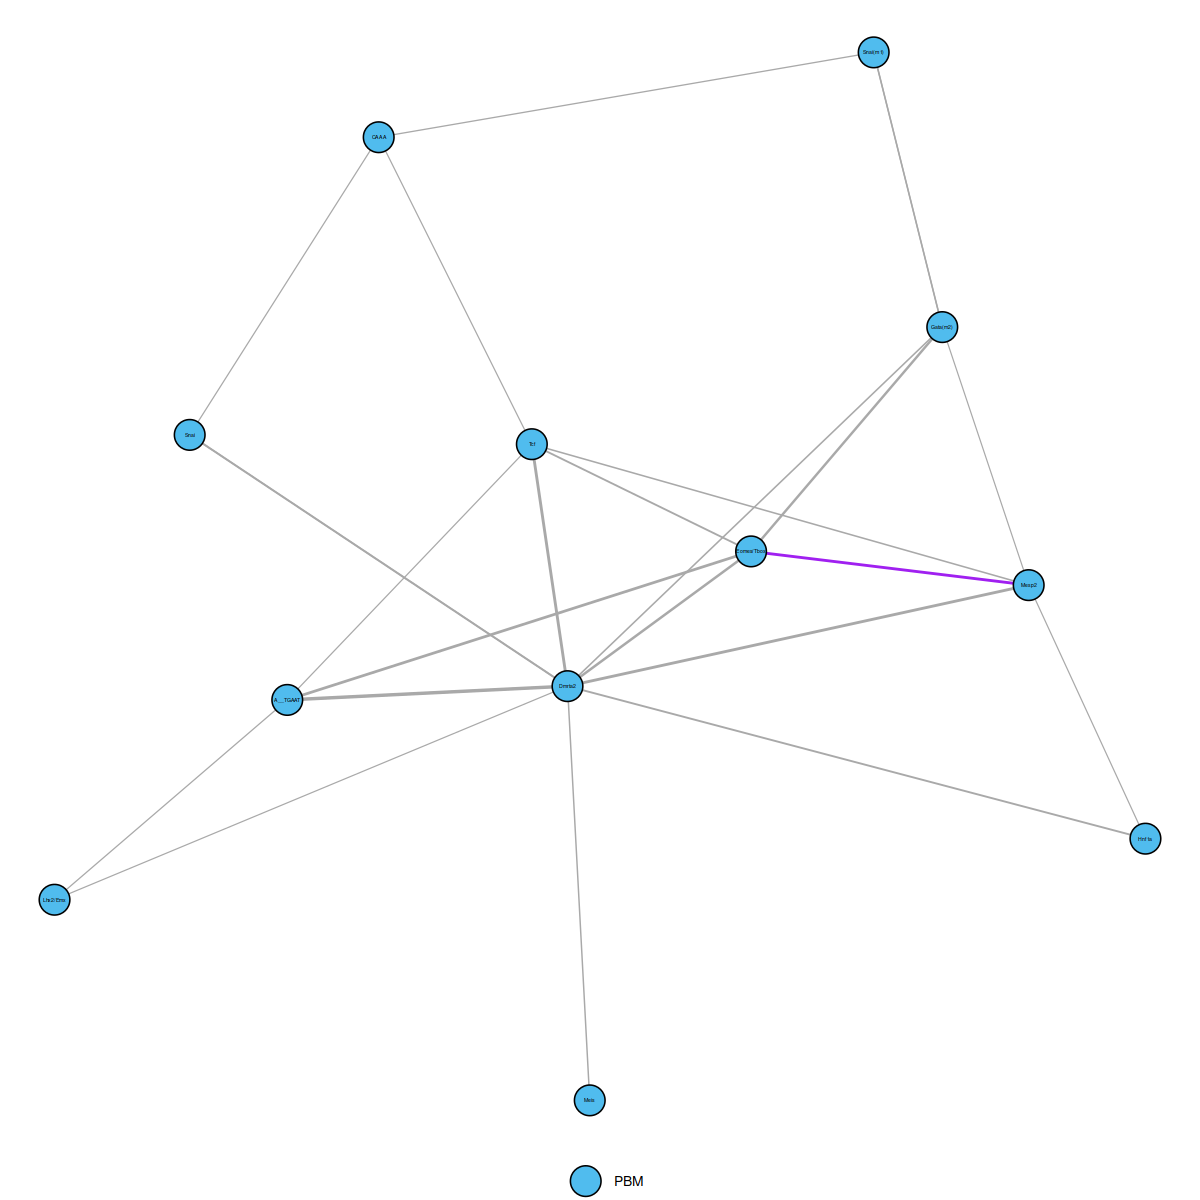

In [24]:
df <- inter_betas %>%
    mutate(edge_color = case_when(
        (tf1 == "Tcf" & tf2 == "K27ac") | (tf1 == "K27ac" & tf2 == "Tcf") ~ "purple",
        (tf1 == "Eomes/Tbox" & tf2 == "Mesp2") | (tf1 == "Mesp2" & tf2 == "Eomes/Tbox") ~ "purple",
        TRUE ~ "darkgray" # Default color
    ))

graph <- df %>%
    select(tf1, tf2, beta, edge_color) %>%
    igraph::graph_from_data_frame(directed = FALSE)

igraph::V(graph)$degree <- igraph::degree(graph)
igraph::V(graph)$type <- ifelse(igraph::V(graph)$name %in% add_key, "Epigenetic-features", "PBM")

# Use a force-directed layout instead of circular
set.seed(60427)
# layout_matrix <- igraph::layout_with_fr(graph)
layout_matrix <- igraph::layout_with_fr(graph, niter = 1000, area = igraph::vcount(graph)^2.3, repulserad = igraph::vcount(graph)^3)

# Scale the layout to ensure it fills the plot area
layout_matrix <- layout_matrix * 1.2


set_plot_size(10, 10)
p <- graph %>%
    ggraph::ggraph(layout = layout_matrix) +
    ggraph::geom_edge_link(alpha = 1, aes(color = edge_color, width = abs(beta))) +
    ggraph::geom_node_point(aes(fill = type), color = "black", size = 8, shape = 21) +
    ggraph::geom_node_text(aes(label = name), repel = FALSE, family = "ArialMT", size = 1) +
    scale_fill_manual(name = "", values = c("Epigenetic-features" = "#309409", "PBM" = "#50bcee")) +
    theme_arial_void() +
    theme(legend.position = "bottom")

p

## Figure 3H

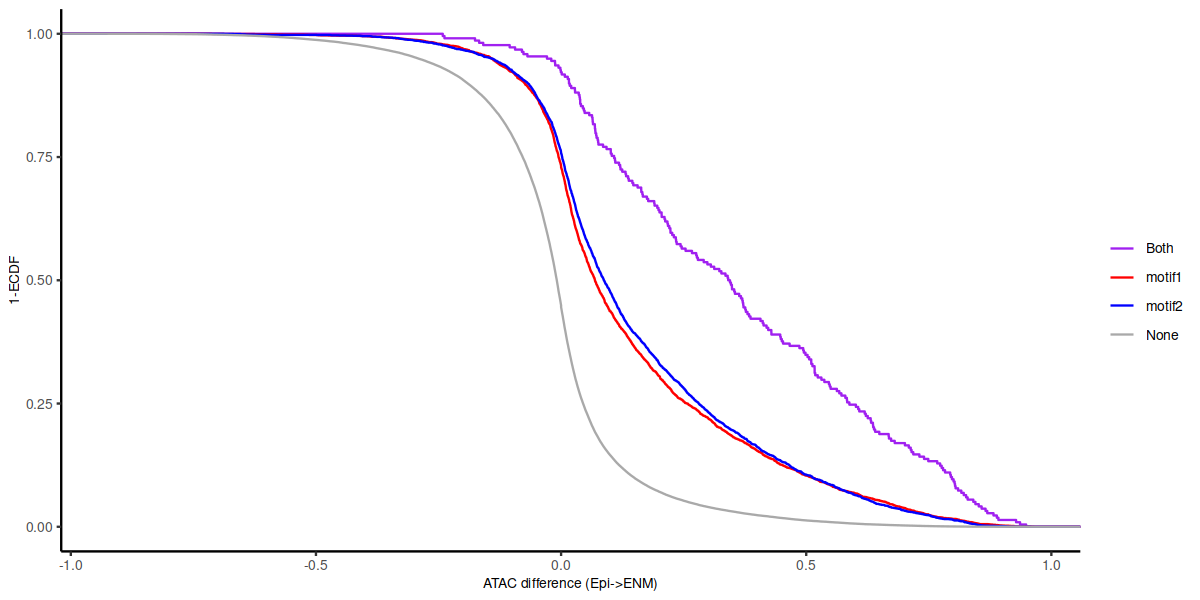

In [25]:
sps(10, 5)
motif1 <- "Mesp2"
motif2 <- "Eomes/Tbox"
energy_threshold <- 8
e_df <- traj_model_meso@normalized_energies[, c(motif1, motif2)] %>% as_tibble()
e_df$type <- case_when(
    e_df[[motif1]] >= energy_threshold & e_df[[motif2]] >= energy_threshold ~ "Both",
    e_df[[motif1]] >= energy_threshold ~ "motif1",
    e_df[[motif2]] >= energy_threshold ~ "motif2",
    TRUE ~ "None"
)
e_df$diff <- traj_model_meso@diff_score
colors <- c("None" = "darkgray", "Both" = "purple", motif1 = "red", motif2 = "blue")
p <- e_df %>%
    ggplot(aes(x = diff, color = type, y = 1 - after_stat(y))) +
    stat_ecdf(linewidth = 0.5) +
    scale_color_manual(name = "", values = colors) +
    xlab("ATAC difference (Epi->ENM)") +
    ylab("1-ECDF")

p

## Figure 3I

In [26]:
compute_inter_pbm_distance <- function(motif1, motif2, traj_model, sequences, energy_threshold = 7) {
    motif1_spat <- prego::compute_local_pwm(sequences, traj_model@motif_models[[motif1]]$pssm, bidirect = TRUE)
    motif1_spat <- norm_energy(motif1_spat, min_energy = -10, q = 1)
    motif1_freq <- motif1_spat >= energy_threshold
    motif2_spat <- prego::compute_local_pwm(sequences, traj_model@motif_models[[motif2]]$pssm, bidirect = TRUE)
    motif2_spat <- norm_energy(motif2_spat, min_energy = -10, q = 1)
    motif2_freq <- motif2_spat >= energy_threshold
    dist_df <- purrr::map_dfr(1:nrow(motif1_freq), ~ {
        motif1_pos <- which(motif1_freq[.x, ])
        motif2_pos <- which(motif2_freq[.x, ])
        if (length(motif1_pos) == 0 | length(motif2_pos) == 0) {
            return(NULL)
        }
        data.frame(id = .x, dist = min(abs(outer(motif1_pos, motif2_pos, "-"))))
    })
    dist_df$diff <- traj_model@diff_score[dist_df$id]
    cli::cli_alert_success("Done computing distance for {.val {motif1}} and {.val {motif2}}")
    return(dist_df)
}

In [27]:
names_key_add <- c(
    m1.SCENIC.jaspar__MA0807.1 = "Eomes/Tbox", m1.JASPAR.Hnf1A = "Hnf1a",
    m1.SCENIC.cisbp__M02420 = "Dmrta2", m2.SCENIC.jaspar__MA0274.1 = "A__TGAAT",
    m2.SCENIC.elemento__GATAAGC = "Gata(m2)", m1.HOCOMOCO.SOX2_MOUSE.H11MO.0.A = "Nanog/Sox",
    m3.SCENIC.jaspar__MA1559.1 = "Snai(m1)", m3.SCENIC.taipale__GRHL1_DBD_NAACCGGTTN_repr = "Grhl1",
    m3.SCENIC.homer__YTGWCADY_Tgif1 = "Meis", m1.SCENIC.elemento__CACCTGG = "Snai",
    m1.SCENIC.homer__TAATTAGN_Lhx2 = "Lhx2/Emx", m4.SCENIC.stark__MATTRRCACNY = "Hoxb2_Tbx",
    m4.SCENIC.swissregulon__hs__EMX1 = "Emx1/Hox", m4.SCENIC.jaspar__MA0037.4 = "Gata3/6",
    m1.SCENIC.taipale_cyt_meth__MESP2_NAMCATATGKYN_eDBD = "Mesp2",
    m3.SCENIC.cisbp__M00198 = "Tcf", m6.SCENIC.flyfactorsurvey__br_Z2_FlyReg_FBgn0000210 = "CAAA",
    m1.HOCOMOCO.SMAD2_HUMAN.H11MO.0.A = "Smad4", m2.SCENIC.jaspar__MA0792.1 = "Pou3",
    m2.SCENIC.cisbp__M00794 = "GTAAACA", m2.JOLMA.FOXL1_di_full = "Foxl",
    m3.JASPAR.HAT1 = "Hnf1b", m3.SCENIC.hdpi__PDLIM5 = "Zic2", m2.SCENIC.cisbp__M00206 = "Sox",
    m6.SCENIC.jaspar__MA0406.1 = "Tead2", m2.JASPAR.Foxl2 = "Foxa2",
    m2.SCENIC.taipale_cyt_meth__FOXA2_NWNWGTMAATATTKRYNYWN_eDBD_meth_repr = "Foxb1",
    m2.SCENIC.nitta__da_TCGGGC40NAAT_KY_ACACSTGCA_m1_c2 = "Snai(m2)",
    m6.HOCOMOCO.ZIC3_MOUSE.H11MO.0.A = "Zic(m2)", m2.SCENIC.taipale_cyt_meth__POU4F3_NTATGCATAN_eDBD_meth_repr = "Pou",
    m4.SCENIC.taipale_cyt_meth__SIX3_NSSTATCRYN_eDBD = "Gata(m4)",
    m3.SCENIC.idmmpmm__oc = "Otx2", m3.SCENIC.cisbp__M01297 = "Nr2f1",
    m3.JASPAR.vfl = "Snai(m3)", m3.SCENIC.flyfactorsurvey__E5_SOLEXA_FBgn0008646 = "Hox(m3)",
    m3.SCENIC.predrem__nrMotif2327 = "TAAGCT", m5.SCENIC.cisbp__M09581 = "Hox(m5)",
    m3.HOMER.Tbx5 = "Tbx(m3)", m5.SCENIC.taipale__HOXC11_DBD_NGYAATWAAAN = "Cdx/Hox",
    m5.JASPAR.HOXC12 = "Cdx(m5)", m5.SCENIC.taipale_cyt_meth__PBX1_KTGATTGAYR_FL = "Hoxa1",
    m5.SCENIC.taipale_cyt_meth__DLX4_NTCGTTAN_eDBD_meth = "Sox3(m3)",
    m6.SCENIC.cisbp__M00787 = "Zic(m3)", m3.HOCOMOCO.CUX2_MOUSE.H11MO.0.C = "Meis1",
    m3.SCENIC.jaspar__MA0787.1 = "Pou(m4)", m4.JASPAR.ARF8 = "GA__A",
    m4.SCENIC.taipale__FOXL1_full_WRTAAAYAAACAA = "Foxp", m4.SCENIC.cisbp__M00779 = "Glis",
    m4.JASPAR.achi = "Meis(m4)", m4.SCENIC.swissregulon__mm__Snai2 = "Snai(m4)",
    m4.SCENIC.cisbp__M00988 = "Znf296?", m4.SCENIC.cisbp__M00002 = "ACACCC",
    m5.SCENIC.homer__CHCAGCRGGRGG_Zic2 = "Zic(m4)", m5.SCENIC.cisbp__M01653 = "ACG",
    m5.SCENIC.hocomoco__MESP1_HUMAN.H11MO.0.D = "Mesp(m4)", m6.HOMER.Smad4 = "Smad(m6)",
    m3.SCENIC.jaspar__MA0200.1 = "Lhx", m5.SCENIC.jaspar__MA0668.2 = "Msgn1",
    m6.SCENIC.predrem__nrMotif65 = "Hand1", m6.SCENIC.hdpi__TFEB = "Snai(m6)",
    m6.SCENIC.taipale_cyt_meth__ZIC4_NRCCMCCYGYNGYGN_eDBD_repr = "Zic(m6)",
    k27me3 = "K27me3", k27ac = "K27ac", k4me1 = "K4me1", k4me3 = "K4me3",
    cg_cont = "CpG cont.", spatial_ratio = "Peak shape", prox_bin1_punc_all = "Reg. ATAC"
)

inter_dist_df <- {
    sequences <- toupper(gseq.extract(traj_model_meso@peak_intervals))
    inter_betas %>%
    rename(var1 = tf1, var2 = tf2) %>%
    filter(type == "PBM-PBM") %>%
    plyr::adply(1, function(row) {
        cli::cli_alert("Computing distance for {.val {row$var1}} and {.val {row$var2}}")
        compute_inter_pbm_distance(row$var1, row$var2, traj_model_meso, sequences) %>% mutate(var1 = row$var1, var2 = row$var2, beta = row$beta)
    }, .parallel = TRUE)    
} %cache_df% here("data/stats/epiblast_to_mesoderm_interaction_distance.tsv")  %>% 
    as_tibble() %>%
    mutate(var1 = names_key_add[var1], var2 = names_key_add[var2], variable = paste(var1, var2, sep = ":"))

Using cached dataframe from '/net/mraid20/ifs/wisdom/tanay_lab/tgdata/users/aviezerl/proj/motif_reg/IQ-paper/data/stats/epiblast_to_mesoderm_interaction_distance.tsv'



In [28]:
dist_df <- inter_dist_df %>%
    filter(variable == "Mesp2:Eomes/Tbox")

In [29]:
df <- dist_df %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300)))

ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(20,50]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(50,100]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(100,200]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(200,300]"], alternative = "less")



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(20,50]"]
D^- = 0.11261, p-value = 0.04943
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(50,100]"]
D^- = 0.1719, p-value = 0.0005985
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(100,200]"]
D^- = 0.23617, p-value = 0.0000003485
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(200,300]"]
D^- = 0.42048, p-value = 7.465e-08
alternative hypothesis: the CDF of x lies below that of y


In [30]:
dist_df %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300))) %>% 
    count(dist)

dist,n
<fct>,<int>
"(0,20]",194
"(20,50]",305
"(50,100]",356
"(100,200]",426
"(200,300]",61


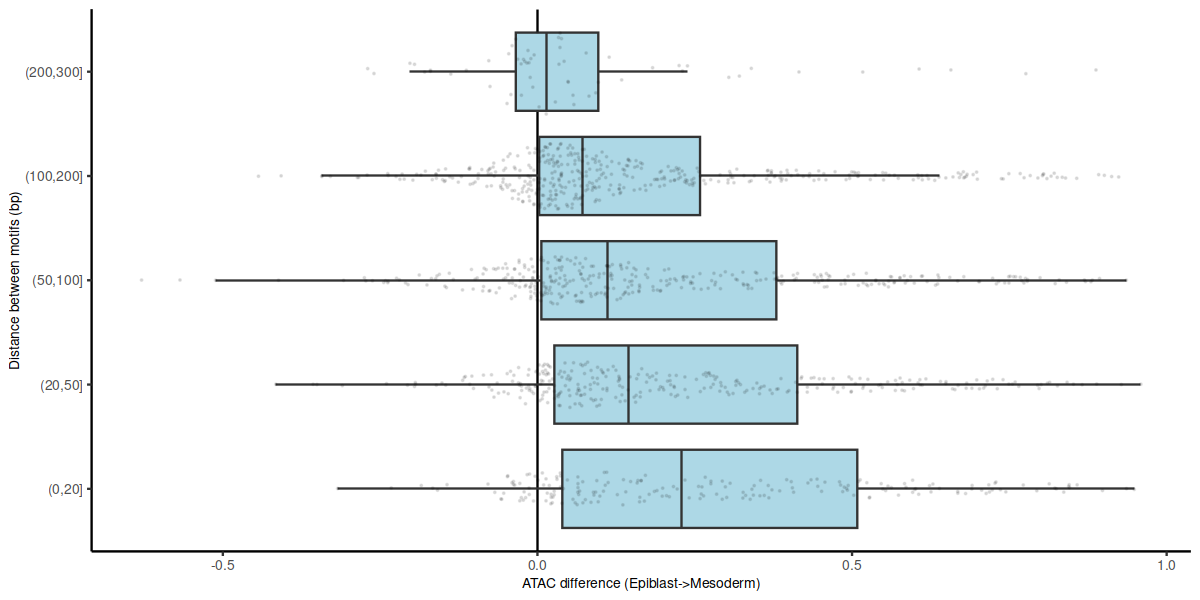

In [31]:
sps(10, 5)
p <- dist_df %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300))) %>%
    ggplot(aes(x = dist, y = diff)) +
    geom_hline(yintercept = 0) +
    geom_boxplot(outliers = FALSE, fill = "lightblue", fatten = 1, linewidth = 0.5) +
    ggforce::geom_sina(size = 0.05, alpha = 0.1) +
    coord_flip() +
    xlab("Distance between motifs (bp)") +
    ylab("ATAC difference (Epiblast->Mesoderm)")


p

## Figure 3J

In [32]:
inter_betas_bm <- fread(here("data/stats/hsc_to_cmp_interaction_beta.csv"))

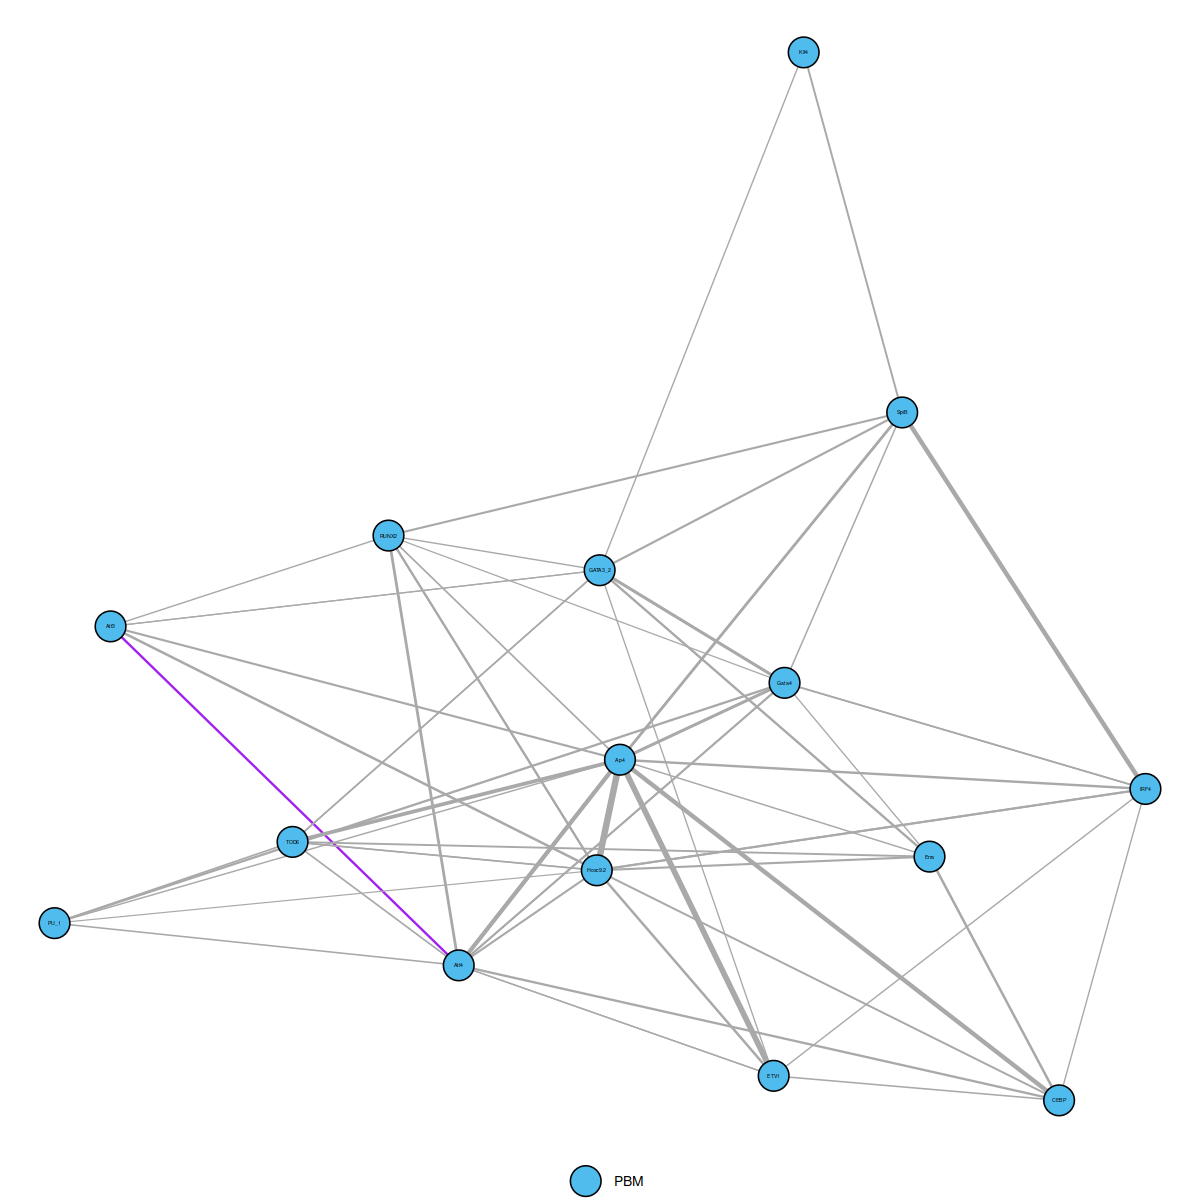

In [33]:
# Filter out weak edges (abs(beta) < 0.25)
df <- inter_betas_bm %>%
    mutate(
        var1 = ifelse(var1 %in% names(add_key), add_key[var1], var1),
        var2 = ifelse(var2 %in% names(add_key), add_key[var2], var2)
    ) %>%
    filter(var1 != "CpG cont.", var2 != "CpG cont.") %>%
    filter(abs(beta) >= 0.25)

# remove epi features
df <- df %>%
    filter(!var1 %in% add_key, !var2 %in% add_key)

df <- df %>%
    mutate(
        edge_color = case_when(
            var1 == "Atf4" & var2 == "Atf3" ~ "purple",
            TRUE ~ "darkgray"
        )
    )

graph <- df %>%
    select(var1, var2, beta, edge_color) %>%
    igraph::graph_from_data_frame(directed = FALSE)

igraph::V(graph)$degree <- igraph::degree(graph)
igraph::V(graph)$type <- ifelse(igraph::V(graph)$name %in% add_key, "Epigenetic-features", "PBM")

# Use a force-directed layout instead of circular
set.seed(60427)
# layout_matrix <- igraph::layout_with_fr(graph)
layout_matrix <- igraph::layout_with_fr(graph, niter = 1000, area = igraph::vcount(graph)^2.3, repulserad = igraph::vcount(graph)^3)

# Scale the layout to ensure it fills the plot area
layout_matrix <- layout_matrix * 1.2


set_plot_size(10, 10)
p <- graph %>%
    ggraph::ggraph(layout = layout_matrix) +
    ggraph::geom_edge_link(alpha = 1, aes(color = edge_color, width = abs(beta))) +
    ggraph::geom_node_point(aes(fill = type), color = "black", size = 8, shape = 21) +
    ggraph::geom_node_text(aes(label = name), repel = FALSE, family = "ArialMT", size = 1) +
    scale_fill_manual(name = "", values = c("Epigenetic-features" = "#309409", "PBM" = "#50bcee")) +
    theme_arial_void() +
    theme(legend.position = "bottom")

p

## Figure 3K

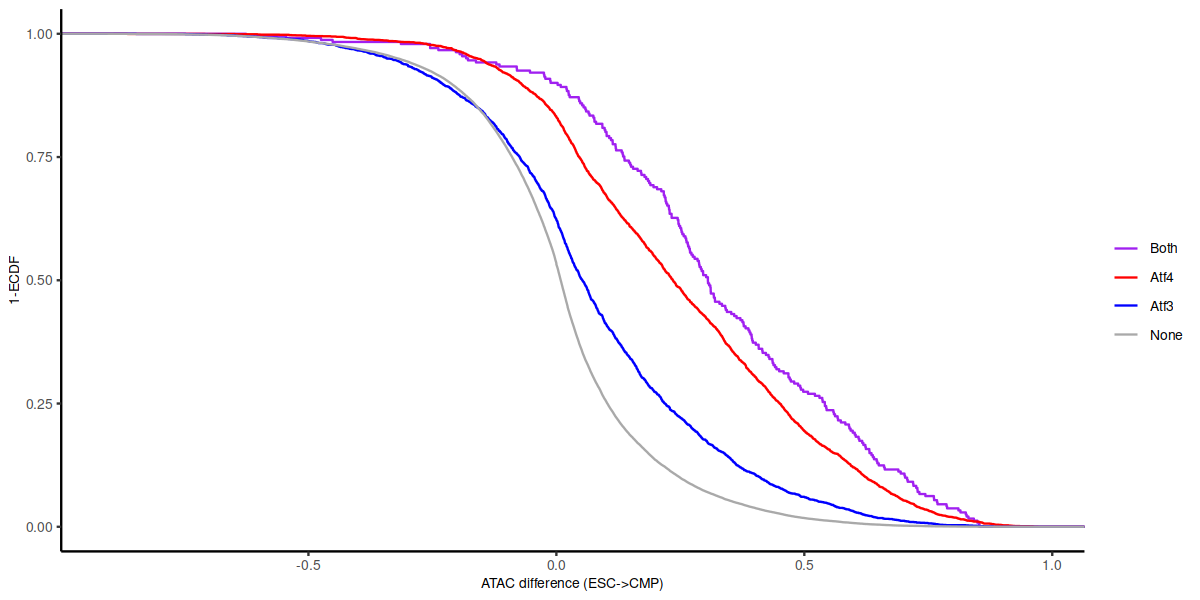

In [34]:
sps(10, 5)
motif1 <- "Atf4"
motif2 <- "Atf3"
energy_threshold <- 8

e_df <- traj_model_bm@normalized_energies[, c(motif1, motif2)] %>% as_tibble()
e_df$type <- case_when(
    e_df[[motif1]] >= energy_threshold & e_df[[motif2]] >= energy_threshold ~ "Both",
    e_df[[motif1]] >= energy_threshold ~ motif1,
    e_df[[motif2]] >= energy_threshold ~ motif2,
    TRUE ~ "None"
)
e_df$diff <- traj_model_bm@diff_score

colors <- c("None" = "darkgray", "Both" = "purple")
colors[motif1] <- "red"
colors[motif2] <- "blue"

p <- e_df %>%
    mutate(type = factor(type, levels = c("Both", motif1, motif2, "None"))) %>%
    ggplot(aes(x = diff, color = type, y = 1 - after_stat(y))) +
    stat_ecdf(linewidth = 0.5) +
    scale_color_manual(name = "", values = colors) +
    xlab("ATAC difference (ESC->CMP)") +
    ylab("1-ECDF")

p

## Figure 3L

In [35]:
gset_genome("hg38")
inter_dist_df_bm <- {
    sequences_bm <- toupper(gseq.extract(traj_model_bm@peak_intervals))
    inter_betas_bm %>%
        filter(type == "PBM-PBM") %>%
        plyr::adply(1, function(row) {
            cli::cli_alert("Computing distance for {.val {row$var1}} and {.val {row$var2}}")
            compute_inter_pbm_distance(row$var1, row$var2, traj_model_bm, sequences_bm) %>% mutate(var1 = row$var1, var2 = row$var2, beta = row$beta)
        }, .parallel = TRUE)
}  %cache_df% here("data/stats/hsc_to_cmp_interaction_distance.csv") %>%
    as_tibble() %>%
    mutate(variable = paste(var1, var2, sep = ":"))
gset_genome("mm10")

Using cached dataframe from '/net/mraid20/ifs/wisdom/tanay_lab/tgdata/users/aviezerl/proj/motif_reg/IQ-paper/data/stats/hsc_to_cmp_interaction_distance.csv'



In [36]:
df <- inter_dist_df_bm %>%
    filter(var1 == "Atf4", var2 == "Atf3") %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300, 500)))

ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(20,50]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(50,100]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(100,200]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(200,300]"], alternative = "less")
ks.test(df$diff[df$dist == "(0,20]"], df$diff[df$dist == "(300,500]"], alternative = "less")


Warning message in ks.test.default(df$diff[df$dist == "(0,20]"], df$diff[df$dist == :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(20,50]"]
D^- = 0.069385, p-value = 0.1489
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(50,100]"]
D^- = 0.086852, p-value = 0.04025
alternative hypothesis: the CDF of x lies below that of y


Warning message in ks.test.default(df$diff[df$dist == "(0,20]"], df$diff[df$dist == :
“p-value will be approximate in the presence of ties”



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(100,200]"]
D^- = 0.14796, p-value = 0.00005095
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(200,300]"]
D^- = 0.1625, p-value = 0.00008062
alternative hypothesis: the CDF of x lies below that of y



	Asymptotic two-sample Kolmogorov-Smirnov test

data:  df$diff[df$dist == "(0,20]"] and df$diff[df$dist == "(300,500]"]
D^- = 0.27276, p-value = 2.346e-09
alternative hypothesis: the CDF of x lies below that of y


In [37]:
inter_dist_df_bm %>%
    filter(var1 == "Atf4", var2 == "Atf3") %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300, 500))) %>%
    filter(!is.na(dist)) %>%
    count(dist)

dist,n
<fct>,<int>
"(0,20]",298
"(20,50]",588
"(50,100]",746
"(100,200]",931
"(200,300]",445
"(300,500]",242


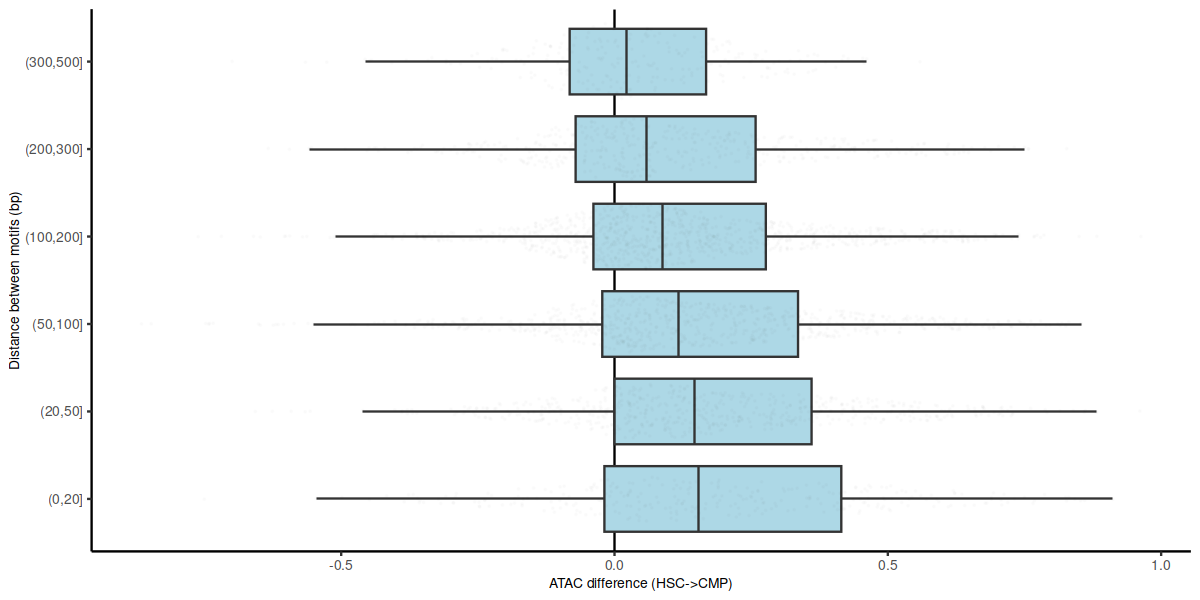

In [38]:
sps(10, 5)
p <- inter_dist_df_bm %>%
    filter(var1 == "Atf4", var2 == "Atf3") %>%
    mutate(dist = cut(dist, breaks = c(0, 20, 50, 100, 200, 300, 500))) %>%
    filter(!is.na(dist)) %>%
    ggplot(aes(x = dist, y = diff)) +
    geom_hline(yintercept = 0) +
    geom_boxplot(outliers = FALSE, fill = "lightblue", fatten = 1, linewidth = 0.5) +
    ggforce::geom_sina(size = 0.05, alpha = 0.01) +
    coord_flip() +
    xlab("Distance between motifs (bp)") +
    ylab("ATAC difference (HSC->CMP)")
p